# Document Clusterng and Topic Modeling

In this project, we use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import re # This module provides regular expression matching operations

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

import lda

## 1. Load Data

Data Source: https://www.kaggle.com/snapcrack/all-the-news

In [2]:
# Read the source file

docs_df = pd.read_csv('articles2.csv')

In [3]:
docs_df.head(n = 5)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,53293,73471,Patriots Day Is Best When It Digs Past the Her...,Atlantic,David Sims,2017-01-11,2017.0,1.0,NaN,"Patriots Day, Peter Berg’s new thriller that r..."
1,53294,73472,A Break in the Search for the Origin of Comple...,Atlantic,Ed Yong,2017-01-11,2017.0,1.0,NaN,"In Norse mythology, humans and our world were ..."
2,53295,73474,Obama’s Ingenious Mention of Atticus Finch,Atlantic,Spencer Kornhaber,2017-01-11,2017.0,1.0,NaN,“If our democracy is to work in this increasin...
3,53296,73475,"Donald Trump Meets, and Assails, the Press",Atlantic,David A. Graham,2017-01-11,2017.0,1.0,NaN,Updated on January 11 at 5:05 p. m. In his fir...
4,53297,73476,Trump: ’I Think’ Hacking Was Russian,Atlantic,Kaveh Waddell,2017-01-11,2017.0,1.0,NaN,Updated at 12:25 p. m. After months of equivoc...


In [4]:
# Randomly choose some documents as our dataset, and get the list of titles and contents

samples = docs_df.sample(n = 100, random_state = 0)
titles = samples['title'].tolist()
contents = samples['content'].tolist()

## 2. Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library. Stop words are words like "a", "the", "in" which don't convey significant meaning. Stemming is the process of breaking a word down into its root. 

In [5]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
print('We use', len(stopwords), 'stop words from nltk library, for example:')
print(stopwords[:10])

We use 153 stop words from nltk library, for example:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']


In [6]:
stemmer = SnowballStemmer(language = 'english')

def tokenization_and_stemming(text):
    
    """
    Break the text into a list of words.
    The words are converted to lower case.
    The words in stopwords defined above are not included.
    Words that don't contain letters are not included.
    Strip the affixes, only return the words after stemming.
    """
    
    tokens = [word.lower() for sent in sent_tokenize(text) for word in word_tokenize(sent) if word not in stopwords]
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token) is not None]
    stems = [stemmer.stem(t) for t in filtered_tokens]
    
    return stems

# without stemming
def tokenization(text):
    
    """
    Break the text into a list of words.
    The words are converted to lower case.
    The words in stopwords defined above are not included.
    Words that don't contain letters are not included.
    """
    
    tokens = [word.lower() for sent in sent_tokenize(text) for word in word_tokenize(sent) if word not in stopwords]
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token) is not None]
    return filtered_tokens

In [7]:
corpus_words_stemmed = [] # list of words (with stemming) in the whole corpus
corpus_words = [] # list of words (without stemming) in the whole corpus

for i in contents:
    tokenized_stemmed = tokenization_and_stemming(i)
    corpus_words_stemmed.extend(tokenized_stemmed)
    tokenized = tokenization(i)
    corpus_words.extend(tokenized)
    
print('Number of stemmed words in the corpus:', len(corpus_words_stemmed))
print('Number of words (not stemmed) in the corpus:', len(corpus_words))

Number of stemmed words in the corpus: 40948
Number of words (not stemmed) in the corpus: 40948


Create a mapping from stemmed words to the original words for result interpretation.

In [8]:
# Create a dictionary, the key is the stemmed word in the corpus, the value is its original word

dict_stem_orig = {corpus_words_stemmed[x] : corpus_words[x] for x in range(len(corpus_words))}
word_eg = 'count'
print('For example, stemmed word:', word_eg, '; original word:', dict_stem_orig[word_eg])

For example, stemmed word: count ; original word: count


## 3. TF-IDF

In [9]:
# From the corpus, choose some terms (using min_df and max_df parameters below), create a document-term matrix.
# The words are stemmed.
# Each row represents each document, each column represents each term.
# The value in the matrix is the Tf-idf result. 

tfidf_model = TfidfVectorizer(min_df = 0.1, max_df = 0.9, max_features = 200000, stop_words = 'english', use_idf = True, 
                             tokenizer = tokenization_and_stemming, ngram_range = (1, 1))
tfidf_matrix = tfidf_model.fit_transform(contents)     
print ('In total, there are', str(tfidf_matrix.shape[0]), 'documents and', str(tfidf_matrix.shape[1]), 'terms')

In total, there are 100 documents and 513 terms


In [10]:
print('TD-IDF model parameters:')
tfidf_model.get_params()

TD-IDF model parameters:


{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.9,
 'max_features': 200000,
 'min_df': 0.1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming(text)>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [11]:
# Save the words selected by the tf-idf model into a list. We will only analyze the documents based on these terms. 

tf_selected_words = tfidf_model.get_feature_names()
print(tf_selected_words[:20])

['abl', 'accord', 'account', 'accus', 'act', 'action', 'activ', 'actual', 'ad', 'addit', 'administr', 'affect', 'agenc', 'ago', 'air', 'alleg', 'allow', 'alreadi', 'alway', 'america']


## 4. Calculate Cosine Similarity of the Documents

cosine similarity (comparing the first document with the rest):
 [1.         0.10605199 0.06261073 0.06194323 0.06389669 0.05562044
 0.03583738 0.22274037 0.08565314 0.52615459 0.21472059 0.26703763
 0.15413023 0.26037847 0.1186227  0.10695646 0.17056939 0.1397837
 0.28485159 0.59795646 0.10886478 0.37819048 0.33854817 0.10527099
 0.11698682 0.09634428 0.12664977 0.14261466 0.17681156 0.1504095
 0.09959089 0.15641689 0.15312543 0.252025   0.477901   0.45393846
 0.1260432  0.14861031 0.08516465 0.33461599 0.14350907 0.21760399
 0.52599093 0.34145139 0.28900567 0.49012321 0.05090438 0.10129833
 0.09714253 0.13106201 0.17761034 0.10568647 0.08325342 0.15245707
 0.21359967 0.38613203 0.13316974 0.29615061 0.08538607 0.10868814
 0.42878481 0.15352506 0.53095948 0.40169334 0.11010654 0.1113355
 0.01779702 0.1536159  0.04275739 0.02990588 0.11083619 0.13925996
 0.19745717 0.1453894  0.37174569 0.263913   0.33274268 0.09930003
 0.25190444 0.37171596 0.04563849 0.29435454 0.01961797 0.37947399


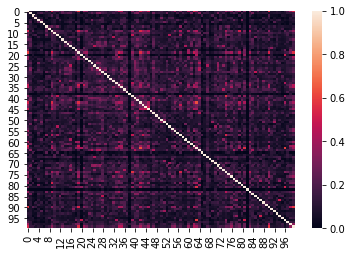

In [12]:
cos_similarity_mat = cosine_similarity(tfidf_matrix)
print('cosine similarity (comparing the first document with the rest):\n', cos_similarity_mat[0])
#fig = plt.figure(figsize = (10,8))
g = sns.heatmap(cos_similarity_mat)

## 5. K-Means Clustering

In [13]:
# Run k-means clustering, assign the documents to different clusters.

num_clusters = 5
km = KMeans(n_clusters = num_clusters, random_state = 3)
km.fit(tfidf_matrix)
cluster_labels = km.labels_.tolist() # list of the assigned cluster of each document. The length equals the number of documents.

### 5.1 Analyze K-Means Result

In [14]:
# Create dataframe

docs = {'title' : titles, 'content' : contents, 'cluster' : cluster_labels}
df = pd.DataFrame(docs, index = [cluster_labels], columns = ['title', 'content', 'cluster'])
df.head(10)

,title,content,cluster
4,Do Republicans Remember When They Promised The...,When Donald Trump was stirring controversy a...,4
2,A Paralysed Man Can Play “Guitar Hero” Using ...,Ian Burkhart shouldn’t be able to move his ha...,2
2,’Keep Our State Straight!’,GOP nominee for attorney general lets loose at...,2
1,"Charlie Sheen Behind $89,398 In Child Support...",Charlie Sheen’s is claiming the “Two and Ha...,1
2,Horndogs are desperate to get arrested by this...,A German policewoman has been swamped with mes...,2
1,This bricklaying robot is going to destroy con...,Robot bricklayers are putting thousands of con...,1
2,‘The Daily Show’ skewers Sean Spicer’s press c...,“The Daily Show” took aim at White House Press...,2
0,4 GOP Senators Flag Concerns With Medicaid Cut...,Four Republicans senators hailing from states ...,0
0,Redesigned 390 Madison Ave. snags another trop...,The law has spoken at 390 Madison Ave. — an...,0
4,Trump is a party of one after he declares war ...,Donald Trump launched a political nuclear on...,4


In [15]:
print('Number of documents included in each cluster:')
df['cluster'].value_counts().to_frame()

Number of documents included in each cluster:


,cluster
2,34
0,22
1,21
4,17
3,6


In [16]:
# Get the center coordinates of each cluster.
# For each cluster center, get the k largest coordinate values. These represent the k most important words for this cluster.

print("Document Clustering Result by K-Means:")
print()
# km.cluster_centers_ denotes the importance of each term in centroid.
# We sort it in decreasing order and get the top k items.
k = 6
order_centroids = km.cluster_centers_.argsort(axis = -1)[:, ::-1] # axis = -1 means the last axis

cluster_keywords_summary = {} # key is the cluster ID, value is a list of keywords
for i in range(num_clusters):
    print('Cluster', str(i), 'words: ', end = '')
    cluster_keywords_summary[i]  = []
    for ind in order_centroids[i, :k]:
        cluster_keywords_summary[i].append(dict_stem_orig[tf_selected_words[ind]])
        print(dict_stem_orig[tf_selected_words[ind]] + ', ', end = '')
    print()
    cluster_titles = df.ix[i]['title'].to_numpy().tolist()
    print('Cluster', str(i), 'titles', "(", str(len(cluster_titles)), 'documents):')
    print(*cluster_titles, sep = '\n')
    print()

Document Clustering Result by K-Means:

Cluster 0 words: clintons, republicans, hillary, courting, elected, trump, 
Cluster 0 titles ( 22 documents):
4 GOP Senators Flag Concerns With Medicaid Cuts In House O’Care Draft Bill
Redesigned 390 Madison Ave. snags another trophy tenant
National Democrats Slander Minnesota’s Jason Lewis
Take To The Streets For A New Progressive Supreme Court Justice
Hillary Clinton Mocks Bonkers GOP Debate With Meme Of Her Looking Bored
 New Ad Attacks Trump On Iran Stances
 A President Just Got Inaugurated Outside His Country And Here’s Why
Democrats fire warning shots at Hillary — and she better listen
Two Awful Candidates Heading to a Close Election
New York’s most intriguing congressional race
The Supreme Court Must Restore Religious Liberty to Military Members
Why Cruz’s Choreographed Courting of Evangelicals Won’t Work
Gennifer Flowers ‘agrees’ to sit front row at first debate
Can the GOP Kill Obamacare?
The Wrong Answer to the South China Sea
Texas gov

In [17]:
cluster_keywords_summary

{0: ['clintons', 'republicans', 'hillary', 'courting', 'elected', 'trump'],
 1: ['said', 'companies', 'reported', 'officials', 'attacks', 'pay'],
 2: ['say', 'like', 'women', 'said', 'years', 'thing'],
 3: ['student', 'school', 'said', 'university', 'increased', 'human'],
 4: ['trump', 'president', 'said', 'republicans', 'campaigns', 'ban']}

### 5.2 Plot K-Means Result

In [18]:
pca = PCA(n_components = 2)

# convert sparse matrix to arrays
tfidf_matrix_np = tfidf_matrix.toarray()

pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)
xs, ys = X[:, 0], X[:, 1]

# set up colors per cluster using a dict
cluster_colors = {0 : '#1b9e77', 1 : '#d95f02', 2 : '#7570b3', 3 : '#e7298a', 4 : '#66a61e'}

# set up cluster names using a dict
cluster_names = {}

for i in range(num_clusters):
    cluster_names[i] = ', '.join(cluster_keywords_summary[i])

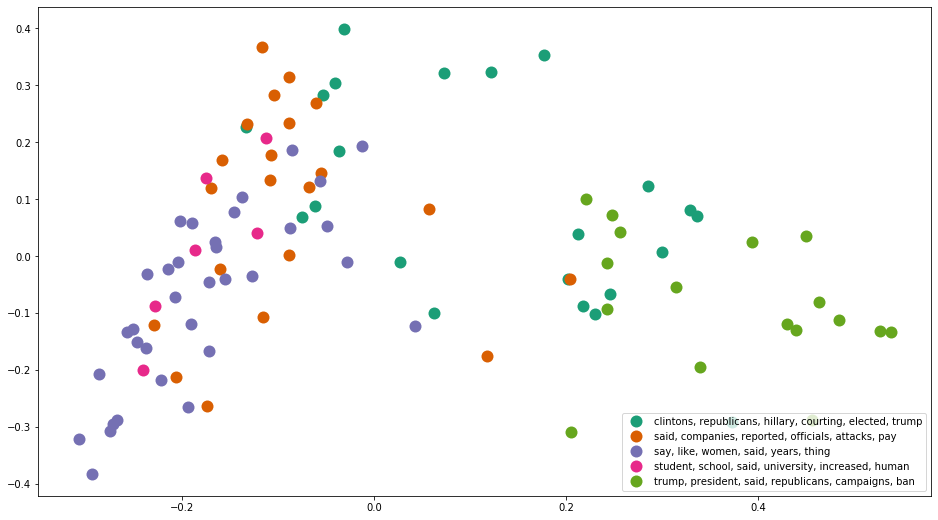

In [19]:
# create dataframe with PCA cluster result
df_pca = pd.DataFrame(dict(x = xs, y = ys, cluster = cluster_labels, title = titles))
groups = df_pca.groupby(by = cluster_labels)

# plot
fig, ax = plt.subplots(figsize = (16, 9))
for name, group in groups:
    ax.plot(group.x, group.y, marker = 'o', linestyle = '', markersize = 12, label = cluster_names[name], 
            markeredgecolor = 'none', color = cluster_colors[name])
ax.legend(numpoints = 1, loc = 4)
plt.show()

## 6. Topic Modeling - Latent Dirichlet Allocation

In [20]:
# Build a dictionary for terms with their indices: {term1 : index1, term2 : index2, ...}
dict_term_index = {tf_selected_words[i] : i for i in range(len(tf_selected_words))}

# Build a feature matrix with shape of (number of documents, number of terms); each item equals the frequency 
# of the term in the corresponding document.
feat_matrix = []
for i in contents:
    cur_doc_tf = [0] * len(tf_selected_words) # build a list of zeros
    doc_words_stemmed = tokenization_and_stemming(i) # a list of stemmed words in current document
    for word in doc_words_stemmed:
        if word in tf_selected_words:
            cur_doc_tf[dict_term_index[word]] += 1
    cur_doc_tf = np.asarray(cur_doc_tf)
    feat_matrix.append(cur_doc_tf)
feat_matrix = np.asarray(feat_matrix) # 2-D numpy array    

In [21]:
# create the LDA model

lda_model = lda.LDA(n_topics = 5, n_iter = 2000, random_state = 1)

**"lda.LDA.topic_word_"** saves the importance of terms in LDA model, i.e., p(word|topic). The shape is (number of topics, number of terms).<br>
**"lda.LDA.doc_topic_"** saves the document topic results, i.e., p(topic|document). The shape is (number of documents, number of topics).

In [ ]:
# Fit the LDA model

lda_model.fit(feat_matrix)

In [23]:
# Calculate p(word|topic), get a list of keywords for each topic 

topic_word = lda_model.topic_word_

# get the top words for each topic
n_top_words = 7
topic_keywords_list = []

for _, topic_dist in enumerate(topic_word): # get each row of topic_word, which is the word distribution of the topic
    cur_topic_keywords = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words-1:-1]
    for i in range(len(cur_topic_keywords)):
        cur_topic_keywords[i] = dict_stem_orig[cur_topic_keywords[i]]
    topic_keywords_list.append(cur_topic_keywords.tolist())

In [24]:
# Calculate p(topic|document), assign the most possible topic to each document, and do document clustering.

doc_topic = lda_model.doc_topic_

topic_doc_dict = {} # key is topic ID, value is list of documents with this topic
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]] # if topicID not in the dictionary yet
    else:
        topic_doc_dict[topicID].append(titles[i])

print("Document clustering result by LDA:")  
print()
for topic in topic_doc_dict:
    print('Cluster', str(topic), 'words:', ', '.join(topic_keywords_list[topic]))
    print('Cluster', str(topic), 'documents (', str(len(topic_doc_dict[topic])), 'documents):')
    print(*topic_doc_dict[topic], sep = '\n')
    print()

Document clustering result by LDA:

Cluster 0 words: trump, republican, president, clintons, campaigns, elected, political
Cluster 0 documents ( 18 documents):
Do Republicans Remember When They Promised They’d Be A Check On Trump?
Trump is a party of one after he declares war on Republicans
Take To The Streets For A New Progressive Supreme Court Justice
It’s Tough Going Through Life Stupid
‘Stay Away’: A ‘Never Trumper’ on Serving in the Trump Administration
Hillary Clinton Mocks Bonkers GOP Debate With Meme Of Her Looking Bored
 New Ad Attacks Trump On Iran Stances
Democrats fire warning shots at Hillary — and she better listen
BREAKING
Two Awful Candidates Heading to a Close Election
New York’s most intriguing congressional race
After Trump’s sweep, does Cruz-Kasich Hail Mary have a prayer?
Why Cruz’s Choreographed Courting of Evangelicals Won’t Work
 Here are 100 Lies and False Statements From Trump’s First 100 Days
Trump Is Rising — and So Is Boris Johnson
Trump Announces Chris Chr